# Lightricks project - Churn Prediction

Lightricks is the creator of popular, award-winning image and video editing applications. This project adresses the churn prediction task for Lightricks' flagship app. 

*The data*

Application usage data and users info were made available to us as a part of DataHack meetup contest. The objective is to solve a pressing business need for Lightricks - predicting which users are likely to churn (cancel their paid subscription). 

*The workflow*

The first part of this project will be data preparation including cleaning, grapghing and feature engineering. The second one will be modeling and predictions.

### Getting started

Some necessary imports

In [1]:
import os
import csv

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import tree
from sklearn.feature_extraction import FeatureHasher

import math
import calendar
import datetime
import dateutil

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

In [2]:
df_usage = pd.read_csv('train_usage_data.csv')
df_users = pd.read_csv('train_users_data.csv',parse_dates = ['installation_date','subscripiton_date'])

backup = df_users.copy()
backup1 = df_usage.copy()

In [5]:
print('usage:')
print()
df_usage.info()
df_usage.head()

usage:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263814 entries, 0 to 263813
Data columns (total 5 columns):
id                263814 non-null int64
feature_name      263814 non-null object
usage_duration    263814 non-null float64
end_use_date      263814 non-null object
accepted          263814 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 8.3+ MB


,id,feature_name,usage_duration,end_use_date,accepted
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False


In [8]:
print('users:')
print()
df_users = df_users.drop(columns='Unnamed: 0')
df_users.info()
df_users.head()

users:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 9 columns):
id                     6998 non-null int64
installation_date      6998 non-null datetime64[ns]
subscripiton_date      6998 non-null datetime64[ns]
country                6996 non-null object
initial_app_version    6998 non-null object
initial_ios_version    6998 non-null object
initial_device         6998 non-null object
days_until_churn       3220 non-null float64
churned                6998 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 492.1+ KB


,id,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,1.9.1,11.2.5,UIDeviceKindIPhoneX,NaN,0
1,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,1.7.5,11.2.1,UIDeviceKindIPhoneX,136.0,0
2,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,1.6,10.3.3,UIDeviceKindIPhone6S,70.0,0
3,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,1.9.5,11.2.6,UIDeviceKindIPhone5S,NaN,0
4,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,1.9.5,11.2.6,UIDeviceKindIPhone8,9.0,1


**Replacing missing values**

In [9]:
df_users['country'].value_counts()

United States           5067
United Kingdom           442
Australia                344
Canada                   267
Sweden                    78
Netherlands               61
Norway                    60
Thailand                  51
Denmark                   44
United Arab Emirates      40
Ireland                   31
New Zealand               26
Romania                   22
Philippines               21
Russia                    21
Poland                    21
Brazil                    20
Israel                    19
Germany                   18
Finland                   18
Belgium                   16
Czechia                   15
Mexico                    14
Saudi Arabia              13
Singapore                 12
Switzerland               11
Turkey                    11
Indonesia                 11
Greece                    10
Lithuania                 10
                        ... 
Cambodia                   1
Ghana                      1
Kosovo                     1
Suriname      

In [10]:
df_users['country'].fillna(value='United States',inplace=True)

**Looking for extreme observations**

In [35]:
for i in df_users.columns:
    print('column', ' ', i, ': ',df_users[i].value_counts().head(10), '\n')
for i in df_usage.columns:
    print('column', ' ', i, ': ',df_usage[i].value_counts().head(10), '\n')

column   id :  230000389898093    1
720000251778047    1
100000422156500    1
290000298144892    1
270000421791609    1
280000311925478    1
570000272453255    1
320000385991728    1
400000406249552    1
140000407527953    1
Name: id, dtype: int64 

column   installation_date :  2018-04-09 03:14:34    2
2018-04-20 04:57:45    2
2018-04-27 15:44:57    2
2018-04-08 02:30:30    2
2018-04-30 06:34:02    1
2017-09-23 16:36:56    1
2016-11-28 04:15:24    1
2018-04-06 20:32:30    1
2017-12-09 18:15:10    1
2018-04-02 05:22:55    1
Name: installation_date, dtype: int64 

column   subscripiton_date :  2018-04-22 04:38:06    2
2018-04-28 18:12:33    2
2018-04-28 18:51:13    2
2018-04-29 19:18:39    2
2018-04-26 04:11:24    2
2018-04-18 04:04:26    2
2018-04-30 00:16:02    2
2018-04-25 12:52:29    1
2018-04-15 03:36:17    1
2018-04-14 19:03:38    1
Name: subscripiton_date, dtype: int64 

column   country :  United States           5069
United Kingdom           442
Australia                344
Can

### Data Preparation

Adding some columns

In [11]:
# Extracting the weekday from each column and than format it as day name (instead of 1,2,3 etc.).
df_users['weekday_installation'] = df_users['installation_date'].apply(datetime.datetime.weekday)
df_users['weekday_installation'] = df_users['weekday_installation'].apply(lambda x: calendar.day_abbr[x])

df_users['weekday_subscripiton'] = df_users['subscripiton_date'].apply(datetime.datetime.weekday)
df_users['weekday_subscripiton'] = df_users['weekday_subscripiton'].apply(lambda x: calendar.day_abbr[x])

In [12]:
# Defining a new function to be used on another column
def day_period(x):
    x = x.hour
    if x >= 6 and x <= 10:
        return 'morning'
    elif x > 10 and x <= 16:
        return 'noon'
    elif x > 16 and x <= 23:
        return 'night'
    else:
        return 'midnight'

In [13]:
df_users['installation_daypart'] = df_users['installation_date'].apply(day_period)
df_users['subscripiton_daypart'] = df_users['subscripiton_date'].apply(day_period)

In [14]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 13 columns):
id                      6998 non-null int64
installation_date       6998 non-null datetime64[ns]
subscripiton_date       6998 non-null datetime64[ns]
country                 6998 non-null object
initial_app_version     6998 non-null object
initial_ios_version     6998 non-null object
initial_device          6998 non-null object
days_until_churn        3220 non-null float64
churned                 6998 non-null int64
weekday_installation    6998 non-null object
weekday_subscripiton    6998 non-null object
installation_daypart    6998 non-null object
subscripiton_daypart    6998 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(8)
memory usage: 710.8+ KB


### Exploratory Data Analysis - EDA

Testing up for correlations

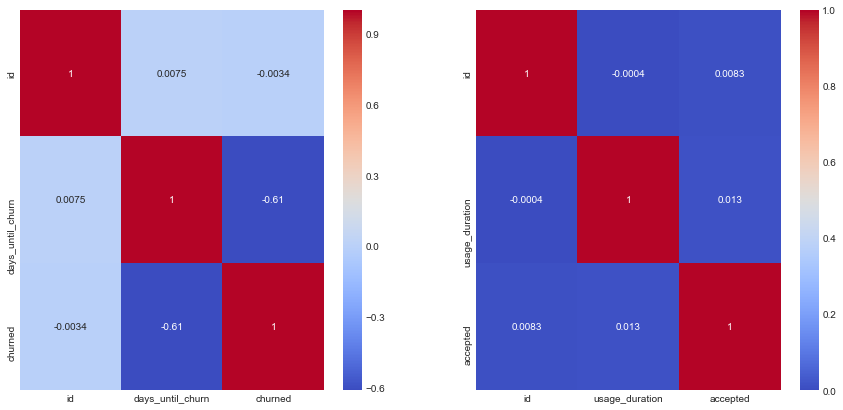

In [21]:
corr_users = df_users.corr()
corr_usage = df_usage.corr()
# .corr() will only imply to the columns that it can use correlation calculation on.

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(data=corr_users, cmap='coolwarm', annot=True)
plt.subplot(1,2,2)
sns.heatmap(data=corr_usage, cmap='coolwarm', annot=True)
plt.show()

Not much to see here really.

In [22]:
joined_df = df_usage.join(df_users.set_index('id'),on='id') # joining the two datasets in order to start the analysis.
df_users['churned']= df_users['churned'].map({1:'Y',0:'N'}) # this is sometimes neccesary when ploting cat' feature in seaborn

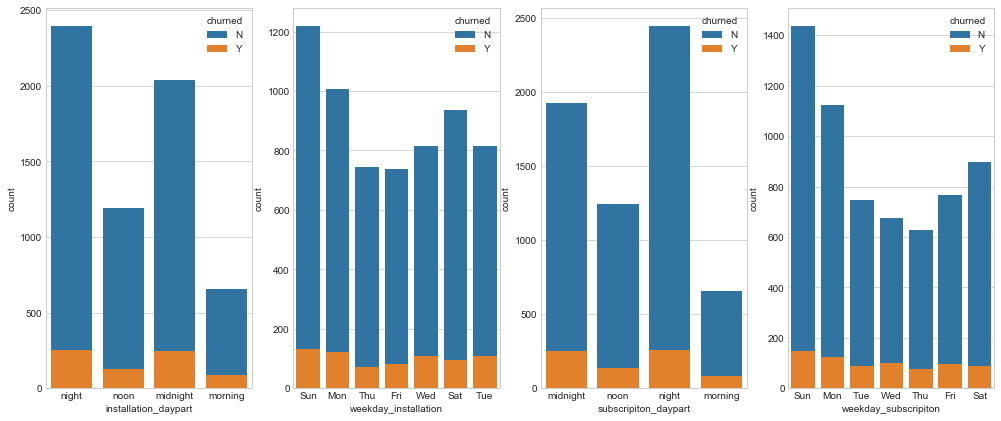

In [27]:
plt.figure(figsize=(17,7))

plt.subplot(1,4,1)
sns.countplot(x='installation_daypart', data=df_users,hue='churned',dodge=False)
plt.subplot(1,4,2)
sns.countplot(x='weekday_installation', data=df_users,hue='churned',dodge=False)
plt.subplot(1,4,3)
sns.countplot(x='subscripiton_daypart', data=df_users,hue='churned',dodge=False)
plt.subplot(1,4,4)
sns.countplot(x='weekday_subscripiton', data=df_users,hue='churned',dodge=False)
plt.show()

It is shown that most of the installations and subscriptions are on sundays and mondays and that night and midnight have significantly more traffic than the other days and day parts.
There was nothing special to report about the distibution of the churn variable, it apears that it is proportional to the hight of the specific bar which is the count of the relevant users.

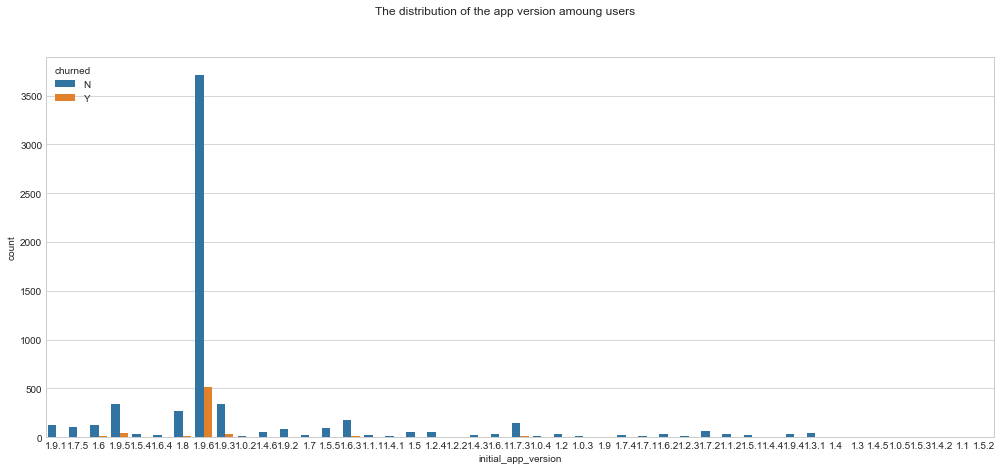

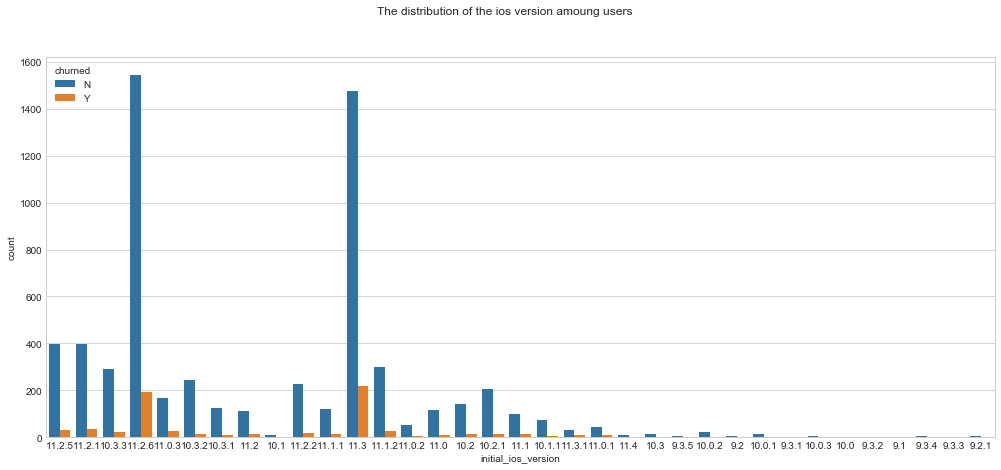

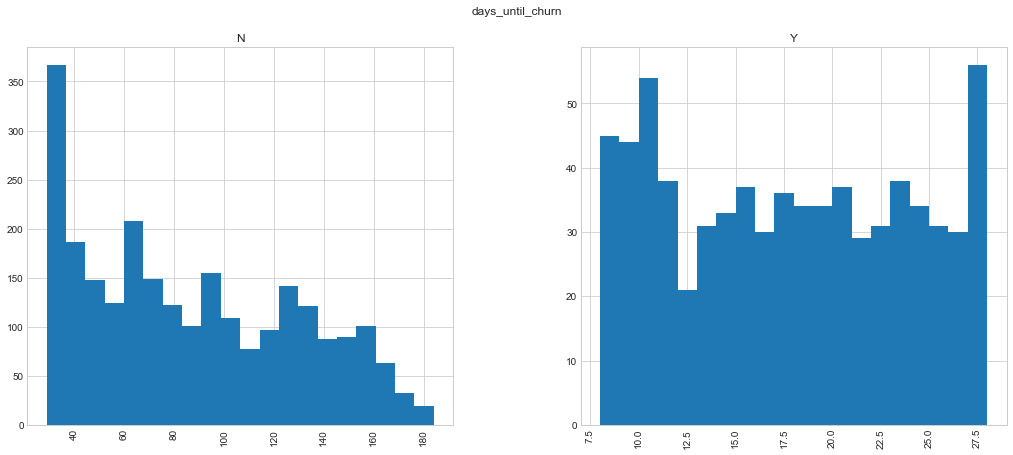

In [32]:
plt.figure(figsize=(17,7))
sns.countplot(x='initial_app_version', data=df_users,hue='churned',dodge=True)
plt.suptitle('The distribution of the app version amoung users')
plt.show() 

plt.figure(figsize=(17,7))
sns.countplot(x='initial_ios_version', data=df_users,hue='churned',dodge=True)
plt.suptitle('The distribution of the ios version amoung users')
plt.show()

df_users['days_until_churn'].hist(bins=20, by=df_users['churned'], figsize=(17,7))
plt.suptitle('days_until_churn')
plt.show()

The first two plots indicates that most of the users use the same app version and that they use it on one of two ios (Apple Iphone operating system) versions.

The third plot needs some explaining before we begin to interperate it. To the left you will see the distribution of the 'days until churn' feature of users that have a label of 'N' in their 'churned' record. It raises the obvious question of how can a user have a 'days until churn' record if he/she hasn't churned?
This can be explained by understanding the frame, scope, of our data. We have been given an access to **one month** of the complete records. That way users who hadn't churn yet at the end of the month got a label of 0 or 'N'. That being said, the personal info about the users included their full, up-to-date, information which holds their details up to the date of the contest.
That is why this graph starts at arround 30 an ends at 180 (the contest took place on October and the data was about April).

Thus, we should focus on the right plot which demonstrate the distribution of the 'days until churn' feature of users that ended up churning that month. The first thing to observe is that there were NO churns during the first 7 or so days. Not a single one. The next thing to pay attention to is that on the next few days churn rates are above the norm than back to normall rates and eventually ends with another peak on the 27th day.

This suggests that users are giving the app seven days of 'grace', than divides into two groups: one that will churn in the next few days and one that will continue to check it up and than churn (if churn) in a steady pace.

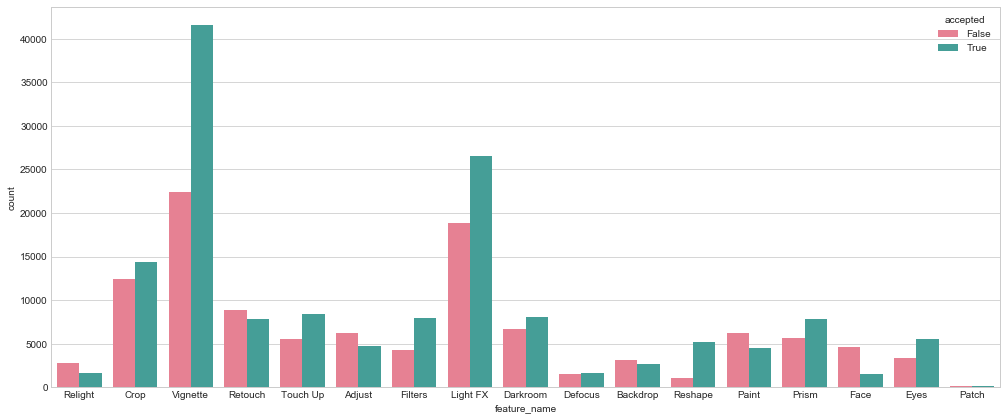

In [34]:
# Checking out the most used features as a function of 'accepted' - if users ended up using that feature in their final item.
plt.figure(figsize=(17,7))
sns.countplot(x='feature_name', data=df_usage,hue='accepted',dodge=True, palette='husl')
plt.show()

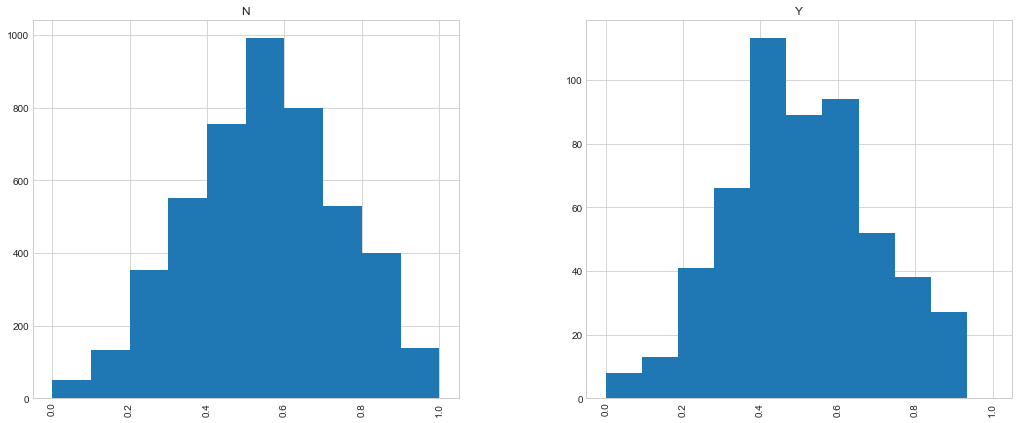

In [44]:
# Building a graph that will show the precentage of acceptance as a function of the churn rate

try_joined_df = joined_df[['id', 'accepted']].copy()
try_joined_df.set_index(keys='id', inplace=True)
try_joined_df['accepted'] = try_joined_df['accepted'].map({True:1,False:0})

pivot = pd.pivot_table(try_joined_df,values= 'accepted', index='id', aggfunc=np.sum)
pivot_df = pd.DataFrame(pivot)

group_count = try_joined_df.groupby(by='id').count().copy()
group_count_df = pd.DataFrame(group_count)

pivot_df['count'] = group_count_df['accepted']
pivot_df['pct_of_acceptance'] = pivot_df['accepted'] / pivot_df['count']

pivot_df = pivot_df.join(df_users.set_index('id'),on='id')
pivot_df = pivot_df.drop(pivot_df[pivot_df['count'] < 10].index)

col_list = ['accepted', 'count', 'installation_date',
       'subscripiton_date', 'country', 'initial_app_version',
       'initial_ios_version', 'initial_device', 'days_until_churn',
       'weekday_installation', 'weekday_subscripiton', 'installation_daypart',
       'subscripiton_daypart']
pivot_df.drop(col_list,axis=1,inplace=True)

pivot_df['pct_of_acceptance'].hist(bins=10,by=pivot_df['churned'],sharex=True, figsize=(17,7))
plt.show()
pivot_df.reset_index(inplace=True)

The most interesting thing accured. It apears that precentage of acceptance has little to no connection to the decision whether or not to churn. It looks like the precentage of acceptance distribute normally over the users regardless their churn decision.

***That insight has led us to believe that using the 'usage' data will only add more noise to the model and that if we will handle it carefully, the information about the users theirself will be enough.***

### Feature Engineering

In [45]:
df_users.drop(['installation_date', 'subscripiton_date','days_until_churn'],axis=1, inplace=True)
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 10 columns):
id                      6998 non-null int64
country                 6998 non-null object
initial_app_version     6998 non-null object
initial_ios_version     6998 non-null object
initial_device          6998 non-null object
churned                 6998 non-null object
weekday_installation    6998 non-null object
weekday_subscripiton    6998 non-null object
installation_daypart    6998 non-null object
subscripiton_daypart    6998 non-null object
dtypes: int64(1), object(9)
memory usage: 546.8+ KB


,id,country,initial_app_version,initial_ios_version,initial_device,churned,weekday_installation,weekday_subscripiton,installation_daypart,subscripiton_daypart
0,100000415577994,Canada,1.9.1,11.2.5,UIDeviceKindIPhoneX,N,Sun,Sun,night,midnight
1,100000415580508,New Zealand,1.7.5,11.2.1,UIDeviceKindIPhoneX,N,Mon,Sun,noon,midnight
2,100000415636784,United States,1.6,10.3.3,UIDeviceKindIPhone6S,N,Thu,Sun,midnight,midnight
3,100000415750897,Turkey,1.9.5,11.2.6,UIDeviceKindIPhone5S,N,Thu,Sun,noon,noon
4,100000415825030,United States,1.9.5,11.2.6,UIDeviceKindIPhone8,Y,Fri,Sun,noon,night


Two ways of representing categorical values were tried - 
Dummies and Feature Hashing

### Dummies

In [46]:
weekday_int = pd.get_dummies(df_users['weekday_installation'], drop_first=True)
weekday_int.columns = ['Mon_inst','Sat_inst','Sun_inst','Thu_inst','Tue_inst','Wed_inst']
df_users = pd.concat([df_users, weekday_int], axis=1)

weekday_sub = pd.get_dummies(df_users['weekday_subscripiton'], drop_first=True)
weekday_sub.columns = ['Mon_sub','Sat_sub','Sun_sub','Thu_sub','Tue_sub','Wed_sub']
df_users = pd.concat([df_users, weekday_sub], axis=1)

daypart_int = pd.get_dummies(df_users['installation_daypart'], drop_first=True)
daypart_int.columns = ['morning_inst','night_inst','noon_inst']
df_users = pd.concat([df_users, daypart_int], axis=1)

daypart_sub = pd.get_dummies(df_users['subscripiton_daypart'], drop_first=True)
daypart_sub.columns = ['morning_sub','night_sub','noon_sub']
df_users = pd.concat([df_users, daypart_sub], axis=1)

### Feature Hashing

In [50]:
# As a first step we will see what number to insert to the hashing function.
# Explaination of feature hashing can be found easelly on Wikipedia

print(df_users['initial_app_version'].value_counts().head(10)) # 8 is enough
print(df_users['initial_ios_version'].value_counts().head(10)) # 10 is enough
print(df_users['initial_device'].value_counts().head(10)) # 8 is enough
df_users['country'].value_counts().head(20) # 15 is more than enough

1.9.6    4225
1.9.5     384
1.9.3     373
1.8       286
1.6.3     189
1.7.3     157
1.9.1     137
1.6       131
1.7.5     111
1.5.5     103
Name: initial_app_version, dtype: int64
11.2.6    1736
11.3      1694
11.2.1     433
11.2.5     432
11.1.2     326
10.3.3     313
10.3.2     260
11.2.2     245
10.2.1     222
11.0.3     194
Name: initial_ios_version, dtype: int64
UIDeviceKindIPhone7Plus     1367
UIDeviceKindIPhone7         1227
UIDeviceKindIPhoneX         1032
UIDeviceKindIPhone8Plus      877
UIDeviceKindIPhone6S         758
UIDeviceKindIPhone8          397
UIDeviceKindIPhone6          379
UIDeviceKindIPhone6SPlus     351
UIDeviceKindIPhoneSE         148
UIDeviceKindIPhone6Plus      138
Name: initial_device, dtype: int64


United States           5069
United Kingdom           442
Australia                344
Canada                   267
Sweden                    78
Netherlands               61
Norway                    60
Thailand                  51
Denmark                   44
United Arab Emirates      40
Ireland                   31
New Zealand               26
Romania                   22
Philippines               21
Russia                    21
Poland                    21
Brazil                    20
Israel                    19
Germany                   18
Finland                   18
Name: country, dtype: int64

In [51]:
fh = FeatureHasher(n_features=8, input_type='string')
app_version_hashed_features = fh.fit_transform(df_users['initial_app_version'])
app_version_hashed_features = app_version_hashed_features.toarray()
app_version_hashed_features_df = pd.DataFrame(app_version_hashed_features)
df_users = pd.concat([df_users, app_version_hashed_features_df], axis=1)
for i in range(0,8):
    df_users.rename(columns={i: 'app_ver_' + str(i)},inplace=True)

fh1 = FeatureHasher(n_features=10, input_type='string')
ios_version_hashed_features = fh1.fit_transform(df_users['initial_ios_version'])
ios_version_hashed_features = ios_version_hashed_features.toarray()
ios_version_hashed_features_df = pd.DataFrame(ios_version_hashed_features)
df_users = pd.concat([df_users, ios_version_hashed_features_df], axis=1)
for i in range(0,10):
    df_users.rename(columns={i: 'ios_ver_' + str(i)},inplace=True)

fh2 = FeatureHasher(n_features=8, input_type='string')
device_version_hashed_features = fh2.fit_transform(df_users['initial_device'])
device_version_hashed_features = device_version_hashed_features.toarray()
device_version_hashed_features_df = pd.DataFrame(device_version_hashed_features)
df_users = pd.concat([df_users, device_version_hashed_features_df], axis=1)
for i in range(0,8):
    df_users.rename(columns={i: 'device_ver_' + str(i)},inplace=True)

fh3 = FeatureHasher(n_features=15, input_type='string')
country_hashed_features = fh3.fit_transform(df_users['country'])
country_hashed_features = country_hashed_features.toarray()
country_hashed_features_df = pd.DataFrame(country_hashed_features)
df_users = pd.concat([df_users, country_hashed_features_df], axis=1)
for i in range(0,15):
    df_users.rename(columns={i: 'country_' + str(i)},inplace=True)

In [52]:
df_users.drop(['country', 'initial_app_version','initial_ios_version', 'initial_device','weekday_installation',
               'weekday_subscripiton', 'installation_daypart', 'subscripiton_daypart'],axis=1, inplace=True)

df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Columns: 102 entries, id to country_14
dtypes: float64(82), int64(1), object(1), uint8(18)
memory usage: 4.6+ MB


,id,churned,Mon_inst,Sat_inst,Sun_inst,Thu_inst,Tue_inst,Wed_inst,Mon_sub,Sat_sub,...,country_5,country_6,country_7,country_8,country_9,country_10,country_11,country_12,country_13,country_14
0,100000415577994,N,0,0,1,0,0,0,0,0,...,3.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
1,100000415580508,N,1,0,0,0,0,0,0,0,...,2.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0
2,100000415636784,N,0,0,0,1,0,0,0,0,...,1.0,-1.0,0.0,0.0,-5.0,-1.0,0.0,0.0,0.0,0.0
3,100000415750897,N,0,0,0,1,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
4,100000415825030,Y,0,0,0,0,0,0,0,0,...,1.0,-1.0,0.0,0.0,-5.0,-1.0,0.0,0.0,0.0,0.0


In [53]:
# Backup and export
final_chosen_DB = df_users.copy()
final_chosen_DB.to_csv('final_chosen_DB.csv')
# This is the end of the first part. Next part is modeling and predictions.